# Data 


In [0]:
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import files

# ---------- File Loading ---------- #
dev_link = 'https://raw.githubusercontent.com/stepmolotov/ML-CUP-2019/master/ML-CUP19-TR.csv'
# dropping comments (first 7 rows)
data = pd.read_csv(dev_link, skiprows=7, header=None)
# print('before: ({},{})'.format(data.shape[0], data.shape[1]))
# dropping indexes column
data.drop(axis=1, columns=0, inplace=True)
# data.head()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_val_score

# ----- Splitting Data ----- #
target = data[data.columns[-2:]]
target.columns = ['x', 'y']
X = data[data.columns[:-2]]
y = target
# y.plot(kind='scatter', x='x', y='y')
print('X: ({},{})'.format(X.shape[0], X.shape[1]))
print('y: ({},{})'.format(y.shape[0], y.shape[1]))

# Scaling
scaler = StandardScaler()
scaler = scaler.fit(X)

#X = scaler.transform(X)

# keeping out some rows as the test set
X = X.values
y = y.values
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

X: (1765,20)
y: (1765,2)


In [0]:
# Gets the best models out of the grid search results
def report(results, n_top=3, metric='loss'):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_'+metric] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("(loss) Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  -1*results['mean_test_loss'][candidate],
                  results['std_test_loss'][candidate]))
            print("(mee) Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_mee'][candidate],
                  results['std_test_mee'][candidate]))
            print("--- Parameters: {0}".format(results['params'][candidate]))
            print("")

from sklearn.metrics import make_scorer

def mean_euclidean_error(X, Y):
    sum = 0
    for x, y in zip(X, Y):
        sum += np.linalg.norm(x - y, ord=2)
    return sum / X.shape[0]

scores = {'loss': 'neg_mean_squared_error', 'mee': make_scorer(mean_euclidean_error)}

# RF

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [0]:

start = time.time()

param_list = {'n_estimators': [100, 200, 250, 500, 750, 1000],            # number of trees in the forest
              'max_depth': [None] + list(np.arange(2, 100, 2)),           # max depth of the tree
              'max_features': ['auto', 'sqrt', 'log2'],                   # number of features to consider at each split
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],          # samples required to split a node
              'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],           # samples required at leaf nodes
              'bootstrap': [True, False]                                  # method of selecting samples for training each tree
             }

# ----- Random Search ----- to narrow down the search of the hyperparameters
RFR = RandomForestRegressor(random_state=42, criterion='mse')
hyp_search = RandomizedSearchCV(estimator=RFR, param_distributions=param_list, verbose=1, n_iter=100, n_jobs=-1, cv=10, scoring=scores, refit='mee', return_train_score=True)
# hyp_search = GridSearchCV(DTC, param_grid=param_list)

hyp_search.fit(train_X, train_y)
end = time.time()
print('Grid time: ' + str(end - start))


In [0]:
results = pd.DataFrame(hyp_search.cv_results_)
results.head()

In [0]:
report(hyp_search.cv_results_, n_top=3, metric='loss')

Model with rank: 1
(loss) Mean validation score: 0.6288 (std: 0.1054)
(mee) Mean validation score: 0.7797 (std: 0.0552)
--- Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 90, 'bootstrap': False}

Model with rank: 2
(loss) Mean validation score: 0.6318 (std: 0.1023)
(mee) Mean validation score: 0.7907 (std: 0.0567)
--- Parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 58, 'bootstrap': False}

Model with rank: 3
(loss) Mean validation score: 0.6529 (std: 0.1017)
(mee) Mean validation score: 0.8124 (std: 0.0561)
--- Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 28, 'bootstrap': False}



### Bootstrap only grid search

In [0]:
param_list = {'n_estimators': [100, 200, 250, 500, 750, 1000],  # number of trees in the forest
              'max_depth': [None] + list(np.arange(2, 100, 2)), # max depth of the tree
              'max_features': ['auto', 'sqrt', 'log2'],         # number of features to consider at each split
              'min_samples_split': list(np.arange(2, 10)),      # samples required to split a node
              'min_samples_leaf': list(np.arange(2, 10)),       # samples required at leaf nodes
              'bootstrap': [True]                               # method of selecting samples for training each tree
             }

# ----- Random Search ----- to narrow down the search of the hyperparameters
RFR = RandomForestRegressor(random_state=42, criterion='mse')
bootstrap_hyp_search = RandomizedSearchCV(estimator=RFR, param_distributions=param_list, verbose=1, n_iter=100, n_jobs=-1, cv=10, scoring=scores, refit=False, return_train_score=True)
# hyp_search = GridSearchCV(DTC, param_grid=param_list)

start = time.time()
bootstrap_hyp_search.fit(train_X, train_y)
end = time.time()
print('Grid time: ' + str(end - start))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 25.8min


Grid time: 1968.5395483970642


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 32.8min finished


In [0]:
report(bootstrap_hyp_search.cv_results_, n_top=5)

Model with rank: 1
(loss) Mean validation score: 0.6882 (std: 0.1034)
(mee) Mean validation score: 0.8663 (std: 0.0472)
--- Parameters: {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 94, 'bootstrap': True}

Model with rank: 2
(loss) Mean validation score: 0.6890 (std: 0.1015)
(mee) Mean validation score: 0.8666 (std: 0.0467)
--- Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 38, 'bootstrap': True}

Model with rank: 2
(loss) Mean validation score: 0.6890 (std: 0.1015)
(mee) Mean validation score: 0.8666 (std: 0.0467)
--- Parameters: {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 94, 'bootstrap': True}

Model with rank: 4
(loss) Mean validation score: 0.6896 (std: 0.1085)
(mee) Mean validation score: 0.8643 (std: 0.0503)
--- Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf':

### Best Model Plots

In [0]:
# best_RFR2 = RandomForestRegressor(random_state=42, criterion='mse', bootstrap=False, max_depth=34, max_features='sqrt', 
#                                   min_samples_leaf=2, min_samples_split=3, n_estimators=250)

best_RFR = RandomForestRegressor(random_state=42, criterion='mse', bootstrap=False, max_depth=90, max_features='log2', 
                                  min_samples_leaf=2, min_samples_split=4, n_estimators=200)

In [7]:
start = time.time()
best_RFR.fit(train_X, train_y)
end = time.time()
print('RFR time: ' + str(end - start)

y_pred = best_RFR.predict(test_X)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred)
print('LOSS : ' + str(mse))
mee = mean_euclidean_error(test_y, y_pred)
print('MEE : ' + str(mee))

RFR time: 1.3793659210205078
LOSS : 0.5887876359263718
MEE : 0.7377576990228514


In [0]:
from sklearn.model_selection import learning_curve
x_size = train_X.shape[0]/10 * 9
print(x_size)
train_sizes = np.arange(1, 1271, 10)
train_sizes, train_scores, validation_scores = learning_curve(estimator=best_RFR, X=train_X, y=train_y, train_sizes=train_sizes, cv=10, scoring='neg_mean_squared_error', verbose=1)

1270.8


In [0]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
# print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
# print('\n', '-' * 20) # separator
# print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1       9.860761e-28
11      1.936708e+00
21      1.585897e-01
31      1.048935e-01
41      1.111358e-01
            ...     
1221    1.552368e-02
1231    1.548692e-02
1241    1.525045e-02
1251    1.511220e-02
1261    1.544874e-02
Length: 127, dtype: float64

 --------------------

Mean validation scores

 1       54.905589
11       9.608537
21       4.495339
31       3.454860
41       3.536435
          ...    
1221     0.652023
1231     0.645395
1241     0.646098
1251     0.635791
1261     0.634521
Length: 127, dtype: float64


Train: 0.0154, Val: 0.6345


(0, 7)

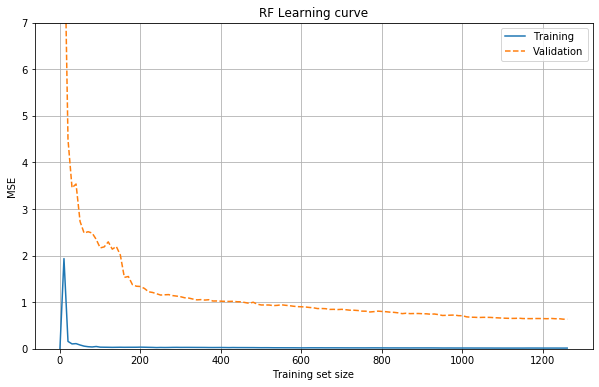

In [0]:
print('Train: %.4f, Val: %.4f' % (train_scores_mean[-1], validation_scores_mean[-1]))
# plot loss during training
plt.figure(figsize=(10,6))#da rivedere
plt.plot(train_sizes, train_scores_mean, label = 'Training')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation', ls='--')
plt.ylabel('MSE')
plt.xlabel('Training set size')
plt.title('RF Learning curve')
plt.legend()
plt.grid()
plt.ylim(0,7)


# Extreme RF



In [0]:
from sklearn.ensemble import ExtraTreesRegressor

In [0]:
start = time.time()

param_list = {'n_estimators': [5, 10, 50, 100, 200, 250, 500, 1000],      # number of trees in the forest
              'max_depth': [None] + list(np.arange(2, 100, 2)),           # max depth of the tree
              'max_features': ['auto', 'sqrt', 'log2'],                   # number of features to consider at each split
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],          # samples required to split a node
              'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],           # samples required at leaf nodes
              'bootstrap': [True, False]                                  # method of selecting samples for training each tree
             }

# ----- Random Search ----- to narrow down the search of the hyperparameters
ETR = ExtraTreesRegressor(random_state=42, criterion='mse')
ETR_hyp_search = RandomizedSearchCV(estimator=ETR, param_distributions=param_list, verbose=1, n_iter=100, n_jobs=-1, cv=10, scoring=scores, refit=False, return_train_score=True)

ETR_hyp_search.fit(train_X, train_y)
end = time.time()
print('Grid time: ' + str(end - start))

Grid time: 240.84288573265076


In [0]:
results_ETR = pd.DataFrame(ETR_hyp_search.cv_results_)
results_ETR.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_loss,split1_test_loss,split2_test_loss,split3_test_loss,split4_test_loss,split5_test_loss,split6_test_loss,split7_test_loss,split8_test_loss,split9_test_loss,mean_test_loss,std_test_loss,rank_test_loss,split0_train_loss,split1_train_loss,split2_train_loss,split3_train_loss,split4_train_loss,split5_train_loss,split6_train_loss,split7_train_loss,split8_train_loss,split9_train_loss,mean_train_loss,std_train_loss,split0_test_mee,split1_test_mee,split2_test_mee,split3_test_mee,split4_test_mee,split5_test_mee,split6_test_mee,split7_test_mee,split8_test_mee,split9_test_mee,mean_test_mee,std_test_mee,rank_test_mee,split0_train_mee,split1_train_mee,split2_train_mee,split3_train_mee,split4_train_mee,split5_train_mee,split6_train_mee,split7_train_mee,split8_train_mee,split9_train_mee,mean_train_mee,std_train_mee
0,0.021896,0.001364,0.003983,0.001167,10,7,2,log2,6,True,"{'n_estimators': 10, 'min_samples_split': 7, '...",-2.184352,-1.393141,-1.933668,-1.757332,-2.184742,-1.776791,-1.733626,-1.585427,-1.583326,-1.833234,-1.796564,0.240810,90,-1.537383,-1.585107,-1.651736,-1.662778,-1.567395,-1.717800,-1.673303,-1.505665,-1.683884,-1.745064,-1.633012,0.075601,1.581055,1.343984,1.492740,1.507914,1.600834,1.508506,1.460515,1.408802,1.413108,1.449807,1.476727,0.074696,11,1.362956,1.387030,1.410250,1.417527,1.385976,1.436637,1.430026,1.346178,1.414240,1.428518,1.401934,0.028755
1,0.419611,0.004763,0.022720,0.001373,200,8,4,sqrt,48,False,"{'n_estimators': 200, 'min_samples_split': 8, ...",-0.992094,-0.728724,-1.085943,-0.892289,-0.954122,-0.719737,-0.715734,-0.819254,-0.695572,-0.790549,-0.839402,0.128607,32,-0.457351,-0.453587,-0.430901,-0.449326,-0.451858,-0.454000,-0.464473,-0.459088,-0.456253,-0.446340,-0.452318,0.008616,1.041991,0.935002,1.112556,1.010500,1.059010,0.974781,0.922142,0.989942,0.948435,0.963906,0.995827,0.057302,70,0.735715,0.735028,0.720622,0.732658,0.735139,0.733645,0.744683,0.735003,0.730360,0.727077,0.732993,0.005936
2,0.643701,0.006214,0.030358,0.003135,250,3,2,sqrt,34,False,"{'n_estimators': 250, 'min_samples_split': 3, ...",-0.770386,-0.559905,-0.887871,-0.667822,-0.745850,-0.547383,-0.507529,-0.570547,-0.519308,-0.585489,-0.636209,0.120490,3,-0.111236,-0.111499,-0.106372,-0.109183,-0.114102,-0.111610,-0.112702,-0.113678,-0.114668,-0.110034,-0.111508,0.002385,0.858499,0.778934,0.938170,0.819293,0.863543,0.807121,0.740951,0.792624,0.772702,0.767305,0.813914,0.055531,97,0.328882,0.328363,0.325324,0.327716,0.331345,0.327297,0.333709,0.333042,0.334281,0.327263,0.329722,0.002970
3,1.152204,0.012850,0.053616,0.004474,500,7,4,sqrt,86,True,"{'n_estimators': 500, 'min_samples_split': 7, ...",-1.166654,-0.837998,-1.278850,-1.024976,-1.137919,-0.866050,-0.859704,-0.923115,-0.881353,-0.957869,-0.993449,0.145045,53,-0.687516,-0.692619,-0.664306,-0.680990,-0.684457,-0.696385,-0.694021,-0.697472,-0.696193,-0.688089,-0.688205,0.009527,1.139890,1.019788,1.212007,1.121918,1.155099,1.072587,1.020955,1.076973,1.068071,1.074739,1.096203,0.057559,47,0.916472,0.918926,0.905447,0.914460,0.915282,0.918506,0.923142,0.922085,0.920771,0.912440,0.916753,0.004971
4,0.725616,0.006195,0.026461,0.003271,250,6,10,auto,14,True,"{'n_estimators': 250, 'min_samples_split': 6, ...",-0.967015,-0.895945,-1.231691,-0.973766,-1.039326,-0.821765,-0.807624,-0.922670,-0.834904,-0.989967,-0.948467,0.119745,50,-0.726207,-0.728303,-0.699859,-0.725649,-0.720103,-0.731670,-0.733978,-0.730822,-0.738424,-0.726197,-0.726121,0.009984,1.076754,1.036785,1.207100,1.081343,1.113998,1.058697,0.970864,1.089571,1.059535,1.052831,1.074748,0.057033,49,0.944691,0.945514,0.932496,0.946892,0.943598,0.944661,0.951908,0.944245,0.946598,0.946609,0.944721,0.004637


In [0]:
report(ETR_hyp_search.cv_results_, n_top=5, metric='loss')

Model with rank: 1
(loss) Mean validation score: 0.6004 (std: 0.1129)
(mee) Mean validation score: 0.7697 (std: 0.0554)
--- Parameters: {'n_estimators': 250, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 52, 'bootstrap': False}

Model with rank: 2
(loss) Mean validation score: 0.6155 (std: 0.1249)
(mee) Mean validation score: 0.7915 (std: 0.0602)
--- Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}

Model with rank: 3
(loss) Mean validation score: 0.6362 (std: 0.1205)
(mee) Mean validation score: 0.8139 (std: 0.0555)
--- Parameters: {'n_estimators': 250, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 34, 'bootstrap': False}

Model with rank: 4
(loss) Mean validation score: 0.6378 (std: 0.1230)
(mee) Mean validation score: 0.8137 (std: 0.0555)
--- Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_lea

### Best Model Plots

In [0]:
# best_RFR2 = RandomForestRegressor(random_state=42, criterion='mse', bootstrap=False, max_depth=34, max_features='sqrt', 
#                                   min_samples_leaf=2, min_samples_split=3, n_estimators=250)

best_ETR = ExtraTreesRegressor(random_state=42, criterion='mse', bootstrap=False, max_depth=52, max_features='auto', 
                                  min_samples_leaf=3, min_samples_split=4, n_estimators=250)

In [9]:
from sklearn.model_selection import cross_validate
ETR_cv = cross_validate(best_ETR, train_X, train_y, cv=10, scoring=scores)
ETR_cv

{'fit_time': array([0.83700252, 0.8116405 , 0.81070018, 0.80320144, 0.80761981,
        0.80845046, 0.82195258, 0.8298192 , 0.80982232, 0.86668515]),
 'score_time': array([0.0182898 , 0.0174551 , 0.01772356, 0.01943755, 0.017097  ,
        0.01766467, 0.01717329, 0.01786017, 0.01822925, 0.01819015]),
 'test_loss': array([-0.67569389, -0.52053604, -0.85040125, -0.66775897, -0.63044249,
        -0.49093908, -0.46334662, -0.54855331, -0.49735664, -0.65859266]),
 'test_mee': array([0.81813757, 0.72909641, 0.89762129, 0.7978218 , 0.77535454,
        0.75057469, 0.68191428, 0.75139317, 0.75538693, 0.74000577])}

In [12]:
ETR_val_loss = -1*ETR_cv['test_loss'].mean()
ETR_val_mee = ETR_cv['test_mee'].mean()
print('ETR Loss: ' + str(ETR_val_loss))
print('ETR MEE: ' + str(ETR_val_mee))

ETR Loss: 0.6003620943530422
ETR MEE: 0.769730643883584


In [13]:
start = time.time()
best_ETR.fit(train_X, train_y)
end = time.time()
print('RFR time: ' + str(end - start))

y_train_pred = best_ETR.predict(train_X)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(train_y, y_train_pred)
print('Train LOSS : ' + str(mse))
mee = mean_euclidean_error(train_y, y_train_pred)
print('Train MEE : ' + str(mee))

y_pred = best_ETR.predict(test_X)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred)
print('Test LOSS : ' + str(mse))
mee = mean_euclidean_error(test_y, y_pred)
print('Test MEE : ' + str(mee))

RFR time: 0.9871265888214111
Train LOSS : 0.08634215391416372
Train MEE : 0.2835738612757258
Test LOSS : 0.6170098741657319
Test MEE : 0.75428156325345


In [0]:
from sklearn.model_selection import learning_curve
x_size = train_X.shape[0]/10 * 9
print(x_size)
train_sizes = np.arange(1, 1271, 10)
train_sizes, train_scores, validation_scores = learning_curve(estimator=best_ETR, X=train_X, y=train_y, train_sizes=train_sizes, cv=10, scoring='neg_mean_squared_error', verbose=1)

1270.8
[learning_curve] Training set sizes: [   1   11   21   31   41   51   61   71   81   91  101  111  121  131
  141  151  161  171  181  191  201  211  221  231  241  251  261  271
  281  291  301  311  321  331  341  351  361  371  381  391  401  411
  421  431  441  451  461  471  481  491  501  511  521  531  541  551
  561  571  581  591  601  611  621  631  641  651  661  671  681  691
  701  711  721  731  741  751  761  771  781  791  801  811  821  831
  841  851  861  871  881  891  901  911  921  931  941  951  961  971
  981  991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111
 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251
 1261]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1270 out of 1270 | elapsed: 10.4min finished


In [0]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
# print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
# print('\n', '-' * 20) # separator
# print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Train: 0.0918, Val: 0.6021


(0, 3)

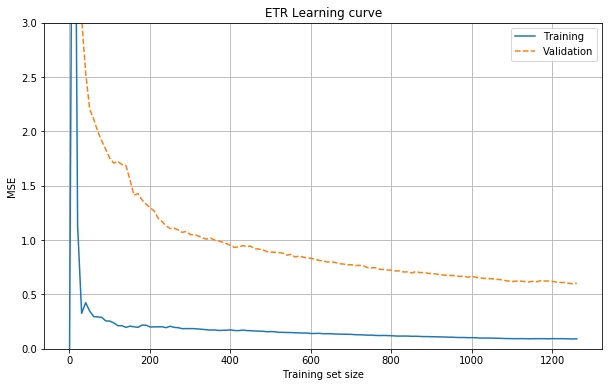

In [0]:
print('Train: %.4f, Val: %.4f' % (train_scores_mean[-1], validation_scores_mean[-1]))
# plot loss during training
plt.figure(figsize=(10,6))#da rivedere
plt.plot(train_sizes, train_scores_mean, label = 'Training')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation', ls='--')
plt.ylabel('MSE')
plt.xlabel('Training set size')
plt.title('ETR Learning curve')
plt.legend()
plt.grid()
plt.ylim(0,3)


# Vs for Appendix

Text(26, -14.5, 'MEE: 0.7378')

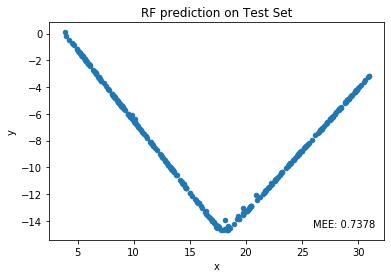

In [0]:
# RF V on our test_X
y_pred = best_RFR.predict(test_X)
y_pred = pd.DataFrame(y_pred, columns=['x', 'y'])

y_pred.plot(kind='scatter', x='x', y='y')
plt.title('RF prediction on Test Set')
plt.text(26,-14.5, 'MEE: 0.7378')
# y_pred.head()

Text(26, -14.5, 'MEE: 0.7543')

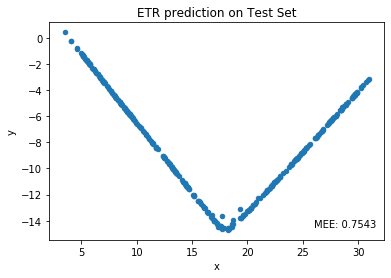

In [12]:
# ETR V on our test_X
y_pred = best_ETR.predict(test_X)
y_pred = pd.DataFrame(y_pred, columns=['x', 'y'])

y_pred.plot(kind='scatter', x='x', y='y')
plt.title('ETR prediction on Test Set')
plt.text(26,-14.5, 'MEE: 0.7543')
# y_pred.head()

# Let's see: Blind Test Results for the ML-CUP

In [0]:
# ---------- File Loading ---------- #
#uploaded = files.upload()
test_link = 'https://raw.githubusercontent.com/stepmolotov/ML-CUP-2019/master/ML-CUP19-TS.csv'
blind_test = pd.read_csv(test_link, skiprows=7, header=None)
blind_test.drop(axis=1, columns=0, inplace=True)

In [45]:
blind_test.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-0.922315,1.101205,-0.489030,0.639825,0.468809,-1.324987,-0.982716,2.086968,-0.922323,0.468824,-1.324990,-1.631460,-1.631477,0.639820,-1.342712,2.086963,-0.982681,-0.489033,1.101214,-1.342723
1,0.593107,-0.981813,-0.397363,-0.966428,-0.728385,0.948562,1.409052,-0.716553,0.593102,-0.728378,0.948559,0.819230,0.819246,-0.966426,1.344650,-0.716564,1.409062,-0.397340,-0.981801,1.344656
2,0.024824,0.425638,2.169535,0.996771,0.750523,0.397398,-0.145573,0.656579,0.024808,0.750509,0.397384,0.630728,0.630703,0.996765,0.030823,0.656575,-0.145566,2.169497,0.425621,0.030826
3,0.782525,-0.531417,-0.214014,-0.074068,0.116700,0.604063,0.272984,-0.602121,0.782530,0.116692,0.604068,0.442205,0.442209,-0.074079,0.030851,-0.602125,0.272983,-0.214004,-0.531415,0.030827
4,-1.048622,0.763405,-1.039072,1.770166,0.750510,-0.842709,-1.281657,0.771010,-1.048618,0.750493,-0.842730,-0.688879,-0.688884,1.770154,-1.402439,0.771014,-1.281661,-1.039074,0.763418,-1.402435


In [46]:
# Training on the whole training dataset
best_ETR.fit(X,y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=52, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=3,
                    min_samples_split=4, min_weight_fraction_leaf=0.0,
                    n_estimators=250, n_jobs=None, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

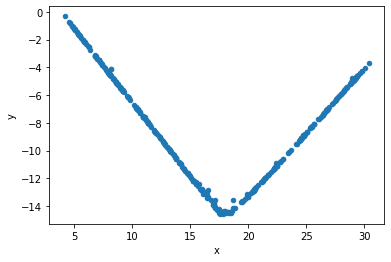

In [47]:
# Output prediction on blind set
y_pred = best_ETR.predict(blind_test)
y_pred = pd.DataFrame(y_pred, columns=['x', 'y'])

y_pred.plot(kind='scatter', x='x', y='y')

In [0]:
# Stefan Daniel Motoc, Gabriele Tenucci
# MoTeN
# ML-CUP19
# 30.01.2020
# id, x, y 
results = pd.DataFrame(y_pred)
filepath = "MoTeN_ML-CUP19-TS.csv"
file = open(filepath, mode='w+')
file.write('# Motoc Stefan Daniel, Tenucci Gabriele\n')
file.write('# MoTeN\n')
file.write('# ML-CUP19\n')
file.write('# 30/01/2019\n')
results.index += 1
results.to_csv(file, sep=',', header=False, index=True)
file.close()
files.download('MoTeN_ML-CUP19-TS.csv')

# Extra 
Trying to avoid using both copies of each column to see whether the predictions become more accurate or the training time diminishes.

In [14]:
corr = data[data.columns[:-2]].corr()
corr.style.background_gradient(cmap='binary').set_precision(2)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,1,-0.86,0.23,-0.82,-0.75,0.85,0.87,-0.82,1,-0.75,0.85,0.54,0.54,-0.82,0.89,-0.82,0.87,0.23,-0.86,0.89
2,-0.86,1,-0.13,0.86,0.79,-0.78,-0.9,0.89,-0.86,0.79,-0.78,-0.39,-0.39,0.86,-0.89,0.89,-0.9,-0.13,1,-0.89
3,0.23,-0.13,1,0.016,0.14,0.39,0.19,-0.17,0.23,0.14,0.39,0.58,0.58,0.016,0.19,-0.17,0.19,1,-0.13,0.19
4,-0.82,0.86,0.016,1,0.88,-0.7,-0.84,0.76,-0.82,0.88,-0.7,-0.28,-0.28,1,-0.84,0.76,-0.84,0.016,0.86,-0.84
5,-0.75,0.79,0.14,0.88,1,-0.62,-0.78,0.71,-0.75,1,-0.62,-0.17,-0.17,0.88,-0.79,0.71,-0.78,0.14,0.79,-0.79
6,0.85,-0.78,0.39,-0.7,-0.62,1,0.81,-0.77,0.85,-0.62,1,0.67,0.67,-0.7,0.83,-0.77,0.81,0.39,-0.78,0.83
7,0.87,-0.9,0.19,-0.84,-0.78,0.81,1,-0.87,0.87,-0.78,0.81,0.45,0.45,-0.84,0.91,-0.87,1,0.19,-0.9,0.91
8,-0.82,0.89,-0.17,0.76,0.71,-0.77,-0.87,1,-0.82,0.71,-0.77,-0.4,-0.4,0.76,-0.88,1,-0.87,-0.17,0.89,-0.88
9,1,-0.86,0.23,-0.82,-0.75,0.85,0.87,-0.82,1,-0.75,0.85,0.54,0.54,-0.82,0.89,-0.82,0.87,0.23,-0.86,0.89
10,-0.75,0.79,0.14,0.88,1,-0.62,-0.78,0.71,-0.75,1,-0.62,-0.17,-0.17,0.88,-0.79,0.71,-0.78,0.14,0.79,-0.79


In [0]:
# ----- Splitting Data ----- #
target = data[data.columns[-2:]]
target.columns = ['x', 'y']
miniX = data[data.columns[:-2]]
miniy = target

In [55]:
# Identical columns to be removed
# 1 = 9
# 2 = 19
# 3 = 18
# 4 = 14
# 5 = 10
# 6 = 11
# 7 = 17
# 8 = 16
# 12 = 13
# 15 = 20
to_drop = [9, 19, 18, 14, 10, 11, 17, 16, 13, 20]
miniX.drop(axis=1, columns=to_drop, inplace=True)
miniX.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,1,2,3,4,5,6,7,8,12,15
0,0.403680,-1.263305,-1.405777,-1.204391,-1.150933,-0.015976,1.050295,-1.345922,-0.500363,1.225213
1,-0.985474,1.495285,-0.947413,0.520832,0.116691,-1.118318,-1.221874,1.572023,-0.971660,-1.223266
2,-0.985464,1.270111,-1.864167,1.234743,1.595580,-1.187201,-1.162063,0.828218,-1.065927,-1.282981
3,0.908829,-0.756618,-0.214001,-0.490480,-1.643876,0.810767,0.272982,-0.430464,0.630728,0.986357
4,-0.543471,0.481930,-0.305679,-0.252544,0.891350,0.466289,-1.281666,0.313303,0.347945,-0.208066


In [0]:
# keeping out some rows as the test set
train_miniX, test_miniX, train_miniy, test_miniy = train_test_split(miniX, miniy, test_size=0.2, random_state=1)

In [0]:
start = time.time()

param_list = {'n_estimators': [5, 10, 50, 100, 200, 250, 500],            # number of trees in the forest
              'max_depth': [None] + list(np.arange(2, 100, 2)),           # max depth of the tree
              'max_features': ['auto', 'sqrt', 'log2'],                   # number of features to consider at each split
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],          # samples required to split a node
              'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],           # samples required at leaf nodes
              'bootstrap': [True, False]                                  # method of selecting samples for training each tree
             }

# ----- Random Search ----- to narrow down the search of the hyperparameters
mini_RFR = RandomForestRegressor(random_state=42, criterion='mse')
mini_hyp_search = RandomizedSearchCV(estimator=mini_RFR, param_distributions=param_list, n_iter=100, n_jobs=-1, cv=10, scoring='neg_mean_squared_error')
mini_extra_hyp_search = ExtraTreesRegressor()
# hyp_search = GridSearchCV(DTC, param_grid=param_list)

mini_hyp_search.fit(train_miniX, train_miniy)

end = time.time()
print('Grid time: ' + str(end - start))

Grid time: 610.0165820121765


In [0]:
best_mini_RFR = mini_hyp_search.best_estimator_
best_mini_RFR

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=32, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
best_ETR = ExtraTreesRegressor(random_state=42, criterion='mse', bootstrap=False, max_depth=52, max_features='auto', 
                                  min_samples_leaf=3, min_samples_split=4, n_estimators=250)

best_ETR_mini = ExtraTreesRegressor(random_state=42, criterion='mse', bootstrap=False, max_depth=32, max_features='log2', 
                                  min_samples_leaf=2, min_samples_split=2, n_estimators=500)

In [60]:
start = time.time()
best_ETR.fit(train_miniX, train_miniy)
end = time.time()
print('Complete model time: ' + str(end - start))
sse = mean_squared_error(test_miniy, ymini_pred)
print('Complete model SSE : ' + str(sse))

start = time.time()
best_ETR_mini.fit(train_miniX, train_miniy)
end = time.time()
print('Mini model time: ' + str(end - start))
ymini_pred = best_ETR_mini.predict(test_miniX)
sse = mean_squared_error(test_miniy, ymini_pred)
print('Mini model SSE : ' + str(sse))

Complete model time: 0.5994677543640137
Complete model SSE : 0.7136321980970437
Mini model time: 0.8181066513061523
Mini model SSE : 0.7136321980970437


In [0]:
mini_ETR = ExtraTreesRegressor(random_state=42, criterion='mse')
mini_extra_hyp_search = RandomizedSearchCV(estimator=mini_ETR, param_distributions=param_list, n_iter=100, n_jobs=-1, cv=10, scoring='neg_mean_squared_error')

mini_extra_hyp_search.fit(train_miniX, train_miniy)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=Fals...
                       

In [0]:
best_mini_ETR = mini_extra_hyp_search.best_estimator_

In [36]:


start = time.time()
best_ETR.fit(train_miniX, train_miniy)
end = time.time()

print('mini ETR time: ' + str(end - start))
y_pred = best_ETR.predict(test_miniX)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_miniy, y_pred)
print('LOSS : ' + str(mse))
mee = mean_euclidean_error(test_miniy.values, y_pred)
print('MEE : ' + str(mee))

mini ETR time: 0.6060011386871338
LOSS : 0.6638746271147202
MEE : 0.8018552912438971


In [0]:
# Correlations of the X value
print('--- X Correlations: ---')
print(data.corr()[21].sort_values())
print()
# Correlations of the Y value
print('--- Y Correlations: ---')
print(data.corr()[22].sort_values())

# columns with the same values are basically the same
# 10 couples of twin values as input
# 1 = 9
# 2 = 19
# 3 = 18
# 4 = 14
# 5 = 10
# 6 = 11
# 7 = 17
# 8 = 16
# 12 = 13
# 15 = 20

--- X Correlations: ---
17   -0.926619
7    -0.926619
20   -0.912118
15   -0.912118
1    -0.852564
9    -0.852564
6    -0.776059
11   -0.776058
12   -0.375713
13   -0.375713
22   -0.277741
18   -0.140206
3    -0.140206
5     0.766070
10    0.766070
4     0.826706
14    0.826706
2     0.927764
19    0.927764
8     0.941095
16    0.941095
21    1.000000
Name: 21, dtype: float64

--- Y Correlations: ---
3    -0.635983
18   -0.635983
5    -0.575801
10   -0.575801
12   -0.556995
13   -0.556994
4    -0.439395
14   -0.439395
2    -0.278078
19   -0.278078
21   -0.277741
16   -0.191277
8    -0.191276
11   -0.125347
6    -0.125346
1     0.110113
9     0.110113
15    0.183254
20    0.183254
7     0.228914
17    0.228915
22    1.000000
Name: 22, dtype: float64
